#### Importando os dados

In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

warnings.filterwarnings("ignore")

url_base = "https://media.githubusercontent.com/media/ruanvirginio/scriptsMestrado/refs/heads/main/Medicoes_2018-2024.csv"
df = pd.read_csv(url_base,  sep=',', encoding='latin-1', skiprows=1)

url_GD = "https://media.githubusercontent.com/media/ruanvirginio/scriptsMestrado/refs/heads/main/EntrantesGD.csv"
gd = pd.read_csv(url_GD,  sep=';', encoding='latin-1')

url_clientes = "https://media.githubusercontent.com/media/ruanvirginio/scriptsMestrado/refs/heads/main/Base_Quantidade_Clientes.csv"
clientes = pd.read_csv(url_clientes, sep=';', encoding='latin-1')

url_clima_patos = "https://media.githubusercontent.com/media/ruanvirginio/scriptsMestrado/refs/heads/main/Clima/dadosSousa.csv"
clima_patos = pd.read_csv(url_clima_patos, sep=';', encoding='latin-1')

df['Potência Ativa'] = pd.to_numeric(df['Potência Ativa'].str.replace(',', '.'), errors='coerce')
df['Potência Reativa'] = pd.to_numeric(df['Potência Reativa'].str.replace(',', '.'), errors='coerce')

gd.rename(columns={
    'Tempo': 'datahora',
}, inplace=True)

In [ ]:
clima_patos['datetime'] = pd.to_datetime(clima_patos['datetime'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            2557 non-null   object        
 1   datetime        2557 non-null   datetime64[ns]
 2   temp            2557 non-null   float64       
 3   precip          2556 non-null   float64       
 4   cloudcover      2557 non-null   float64       
 5   solarradiation  2556 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 120.0+ KB


#### Funções para tratar Outliers

In [ ]:
# Função para aplicar o filtro IQR
def filtrar_coluna_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 3.2 * IQR

    return df[(df[coluna] >= lower_bound) & (df[coluna] <= upper_bound)]

# Função para aplicar o filtro baseado em Média Móvel
def filtrar_coluna_media_movel(df, coluna, janela=20, threshold=4):

    media_movel = df[coluna].rolling(window=janela, center=True).mean()
    desvio = np.abs(df[coluna] - media_movel)

    limite_superior = media_movel + threshold * desvio.std()
    limite_inferior = media_movel - threshold * desvio.std()

    return df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]

# Função para aplicar o filtro baseado em Z-Score
def filtrar_coluna_zscore(df, coluna, threshold=3):
    media = df[coluna].mean()
    desvio_padrao = df[coluna].std()
    z_scores = (df[coluna] - media) / desvio_padrao

    return df[np.abs(z_scores) < threshold]

# Função que aplica o filtro escolhido
def aplicar_filtro(df, coluna, metodo='iqr', janela=20, threshold=4, z_threshold=3):
    if metodo == 'iqr':
        return filtrar_coluna_iqr(df, coluna)
    elif metodo == 'media_movel':
        return filtrar_coluna_media_movel(df, coluna, janela=janela, threshold=threshold)
    elif metodo == 'zscore':
        return filtrar_coluna_zscore(df, coluna, threshold=z_threshold)
    else:
        raise ValueError("Método inválido! Escolha entre 'iqr', 'media_movel' ou 'zscore'.")


#### Tratamento dos Dados

In [ ]:
## Tratando "CLIENTES"

clientes['DATA'] = pd.to_datetime(clientes['DATA'])

# One-hot encoding nas colunas de interesse
dummies = pd.get_dummies(clientes[['CLASSE', 'DSC_GRUPO_FORNECIMENTO']].astype(str),
                         prefix=['classe', 'fornec'])

# Multiplicando cada coluna pelo valor de QTD_CLIENTES
dummies_mult = dummies.multiply(clientes['QTD_CLIENTES'], axis=0)

# Concatenando com as colunas TRAFO e DATA
df_transf = pd.concat([clientes[['TRAFO', 'DATA']], dummies_mult], axis=1)

# Se por acaso houver mais de uma linha para uma mesma combinação de TRAFO e DATA, somamos
df_final = df_transf.groupby(['TRAFO', 'DATA']).sum().reset_index()

# Essa clase não existe
df_final.drop('classe_0', axis=1)

df_final.rename(columns={
    'DATA': 'datahora',
}, inplace=True)

clima_patos.rename(columns={
    'datetime': 'datahora',
}, inplace=True)

In [ ]:
df.rename(columns={
    'Potência Ativa': 'P',
    'Potência Reativa': 'Q',
    'Data/Hora Medição': 'datahora',
    'Equipamento Medição': 'TRAFO'
}, inplace=True)

df['datahora'] = pd.to_datetime(df['datahora'], format='%d/%m/%Y %H:%M:%S')
gd['datahora'] = pd.to_datetime(gd['datahora'], format='%Y-%m-%d %H:%M:%S')
clima_patos['datahora'] = pd.to_datetime(clima_patos['datahora'], format='%Y-%m-%d')

df = pd.merge(df, gd, on=['datahora', 'TRAFO'])

df = pd.merge(df, df_final, on=['datahora', 'TRAFO'])

df['P'] = df['P'].abs()  # salvando o módulo dos valores
df['Q'] = df['Q'].abs()
df['S'] = np.sqrt(df['P']**2 + df['Q']**2)  # Calculando a potência aparente (S), em kVA

# Removendo linhas com S = 0
df = df[df['S'] != 0]

# DataFrame final para armazenar os dados filtrados
df_filtrado = pd.DataFrame()

# Escolha do método de filtragem ('iqr', 'media_movel' ou 'zscore')
metodo_filtro = 'iqr'

# Aplicando o filtro pra limpar os outliers pra cada transformador
for trafo in df['TRAFO'].unique():
    df_trafo = df[df['TRAFO'] == trafo]

    df_trafo_filtrado = aplicar_filtro(df_trafo, 'S', metodo=metodo_filtro, janela=20, threshold=4, z_threshold=3)

    # Adicionar os dados filtrados ao DataFrame final
    df_filtrado = pd.concat([df_filtrado, df_trafo_filtrado], ignore_index=True)

# Ordenando e removendo duplicatas
df_filtrado = df_filtrado.sort_values(by=['TRAFO', 'datahora'])
df_filtrado = df_filtrado.drop_duplicates(subset=['datahora', 'TRAFO'])

In [ ]:
lista_trafos = df_filtrado['TRAFO'].unique().tolist()

In [ ]:
# # Lista de transformadores para análise
trafos_escolhidos = [
    # LESTE
    # 'BSA_DJ_12B1', 'CAA_DJ_12B1', 'MAA_DJ_12B1',

    # # CENTRO
    # 'ARA_DJ_12B1', 'BQR_DJ_12B1', 'RIC_DJ_12B1',

    # # OESTE
    'SZA_DJ_12T1', 'SZA_DJ_12B2',
    # 'PTS_DJ_12B1'
]

# trafos_escolhidos  = lista_trafos


# Criando gráfico da Potência Aparente ao longo do tempo, separada por TRAFO
# fig_aparente = px.line(df_filtrado, x='datahora', y='S', color='TRAFO',
#                        title='Potência Aparente ao Longo do Tempo por Transformador',
#                        labels={'S': 'Potência Aparente (kVA)', 'Dia': 'Data'})

# Exibir ou salvar o gráfico em
# fig_aparente.show()
# fig_aparente.write_html("Demanda ao longo do tempo - IQR.html")

In [ ]:
df_filtrado = pd.merge(df_filtrado, clima_patos, on='datahora')
df_filtrado

,TRAFO,datahora,P,Q,PotenciaAcumulada,classe_0,classe_1,classe_2,classe_3,classe_4,...,classe_7,classe_8,fornec_ALTA,fornec_BAIXA,S,name,temp,precip,cloudcover,solarradiation
0,ABR_DJ_12B1,2019-02-13,9.90,0.00,0.01,0,28064,73,2899,3547,...,15,2,72,34832,9.90,Patos,26.20,12.70,95.70,143.80
1,ABR_DJ_12B1,2019-02-14,8.80,0.00,0.01,0,28064,73,2901,3547,...,15,2,72,34834,8.80,Patos,26.00,9.70,98.20,197.40
2,ABR_DJ_12B1,2019-02-15,9.70,0.00,0.02,0,28065,73,2901,3547,...,15,2,72,34835,9.70,Patos,27.60,25.70,92.50,212.30
3,ABR_DJ_12B1,2019-02-16,10.00,0.00,0.03,0,28065,73,2902,3547,...,15,2,72,34836,10.00,Patos,26.40,8.60,98.60,195.70
4,ABR_DJ_12B1,2019-02-17,10.30,0.00,0.03,0,28067,73,2902,3547,...,15,2,72,34838,10.30,Patos,27.00,8.40,92.00,233.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153053,URN_DJ_12B1,2024-08-26,1.26,0.22,2.44,0,10051,7,801,1570,...,37,2,20,12779,1.28,Patos,27.70,0.00,19.40,294.70
153054,URN_DJ_12B1,2024-12-28,1.67,0.34,2.64,0,10112,6,781,1570,...,38,2,20,12843,1.70,Patos,30.70,0.00,20.20,300.70
153055,URN_DJ_12B1,2024-12-29,1.66,0.35,2.64,0,10112,6,781,1570,...,38,2,20,12843,1.70,Patos,30.70,0.00,14.50,300.20
153056,URN_DJ_12B1,2024-12-30,1.65,0.29,2.64,0,10112,6,781,1570,...,38,2,20,12843,1.68,Patos,30.50,0.10,22.30,304.70


#### S + Potência Acumulada GD + Clima

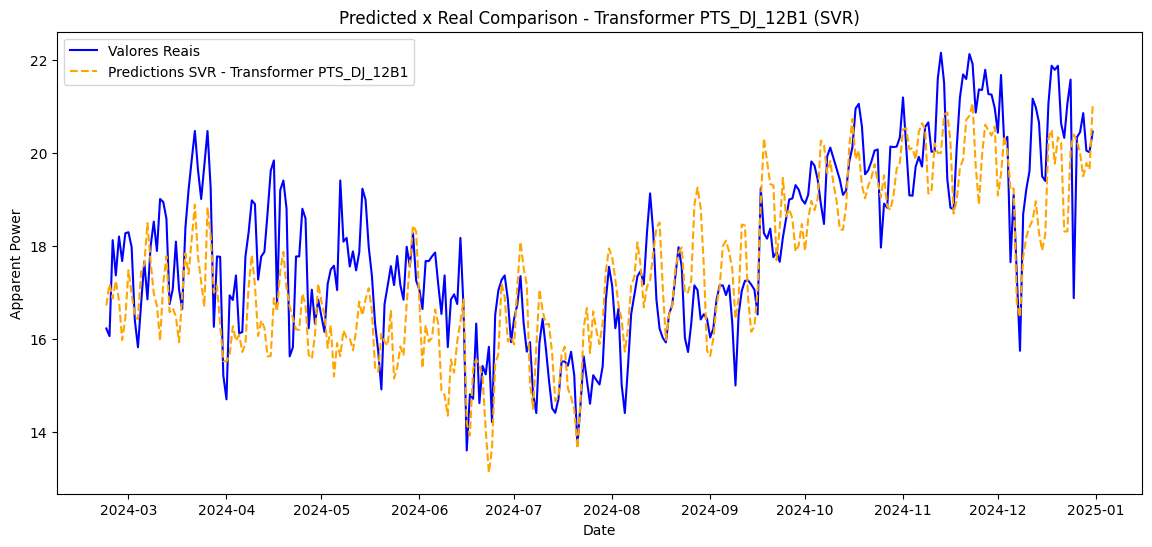

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step


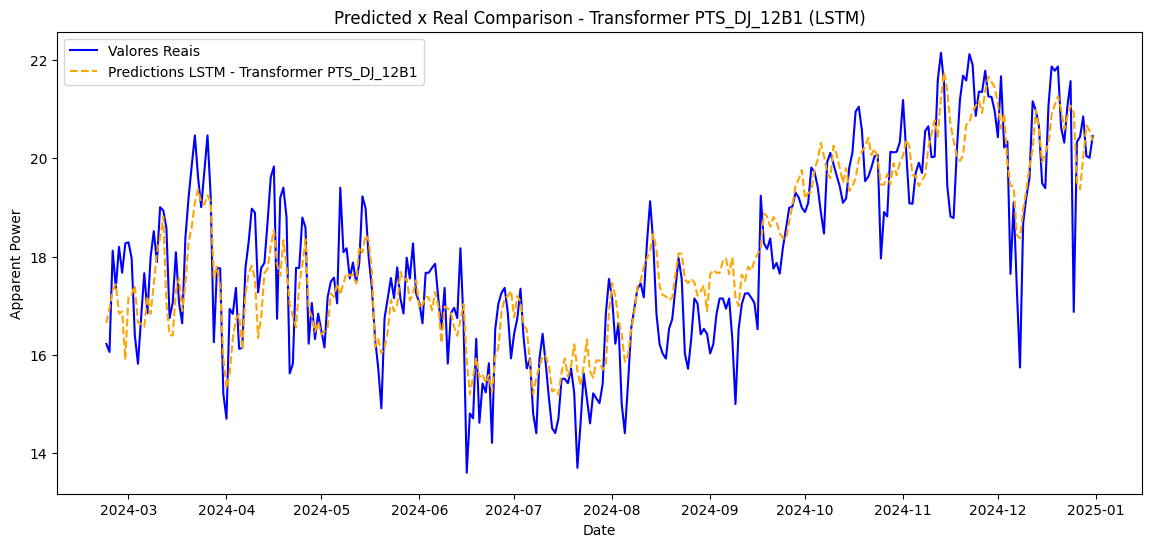

Resultados SVR:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1    SVR  1.26 1.04 0.56

Resultados LSTM:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1   LSTM  0.86 0.68 0.80


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import random

# Fixando seeds para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

def plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo):
    plt.figure(figsize=(14, 6))
    plt.plot(df_previsoes, y_test_inverso, label='Valores Reais', color='blue')
    plt.plot(df_previsoes, y_pred, label=f'Predictions {modelo} - Transformer {trafo}', linestyle='--', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Apparent Power')
    plt.title(f'Predicted x Real Comparison - Transformer {trafo} ({modelo})')
    plt.legend()
    plt.show()

def treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo, janela, epochs=20, batch_size=32):
    resultados = []

    for trafo in trafos_escolhidos:
        df = df_filtrado[df_filtrado['TRAFO'] == trafo]
        df = df[['datahora', 'S', 'PotenciaAcumulada', 'fornec_ALTA', 'fornec_BAIXA', 'temp', 'precip',	'cloudcover',	'solarradiation']]
        df = df.set_index(['datahora']).resample('D').max()
        df.sort_index(inplace=True)
        df = df.interpolate(method='linear')

        dados = df[['S', 'PotenciaAcumulada', 'temp', 'precip',	'cloudcover',	'solarradiation']].values
        scaler_features = MinMaxScaler(feature_range=(0, 1))
        dados_normalizados = scaler_features.fit_transform(dados)

        scaler_S = MinMaxScaler(feature_range=(0, 1))
        S_normalizado = scaler_S.fit_transform(df[['S']].values)

        X, y = [], []
        for i in range(janela, len(dados_normalizados)):
            X.append(dados_normalizados[i-janela:i, :])
            y.append(dados_normalizados[i, 0])  # Prevendo apenas "S"

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2])) if modelo == 'LSTM' else X.reshape(X.shape[0], -1)

        split = int(len(X) * 0.83)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        if modelo == 'SVR':
            regressor = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=0.01)

        elif modelo == 'RFR':
            regressor = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt', n_jobs=-1, random_state=42)

        elif modelo == 'LSTM':
            regressor = Sequential()
            regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            regressor.add(LSTM(units=50))
            regressor.add(Dense(1))
            regressor.compile(optimizer='adam', loss='mean_squared_error')
            regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        regressor.fit(X_train, y_train) if modelo != 'LSTM' else None

        y_pred_normalizado = regressor.predict(X_test)  # forma (n_amostras, 1)
        y_pred = scaler_S.inverse_transform(y_pred_normalizado.reshape(-1, 1))
        y_test_inverso = scaler_S.inverse_transform(y_test.reshape(-1, 1))


        mse = mean_squared_error(y_test_inverso, y_pred)
        rmse = sqrt(mse)
        mae = mean_absolute_error(y_test_inverso, y_pred)
        r2 = r2_score(y_test_inverso, y_pred)

        df_previsoes = df.index[split + janela:]
        plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo)

        resultados.append({
            'Trafo': trafo,
            'Modelo': modelo,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

    return pd.DataFrame(resultados)

# Chamando para SVR, RFR e LSTM
resultados_svr_S_GD_Clima = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='SVR', janela=365)
# resultados_rfr = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='RFR', janela=365)
resultados_lstm_S_GD_Clima = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='LSTM', janela=365, epochs=20, batch_size=32)

print("Resultados SVR:")
print(resultados_svr_S_GD_Clima)
# print("\nResultados RFR:")
# print(resultados_rfr)
print("\nResultados LSTM:")
print(resultados_lstm_S_GD_Clima)

#### S + Clientes

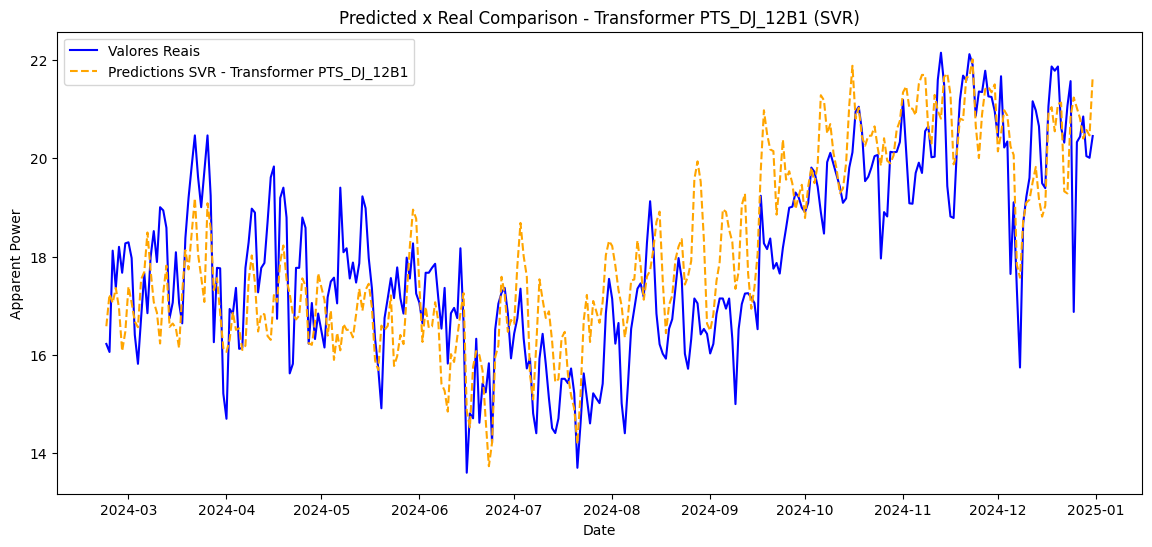

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step


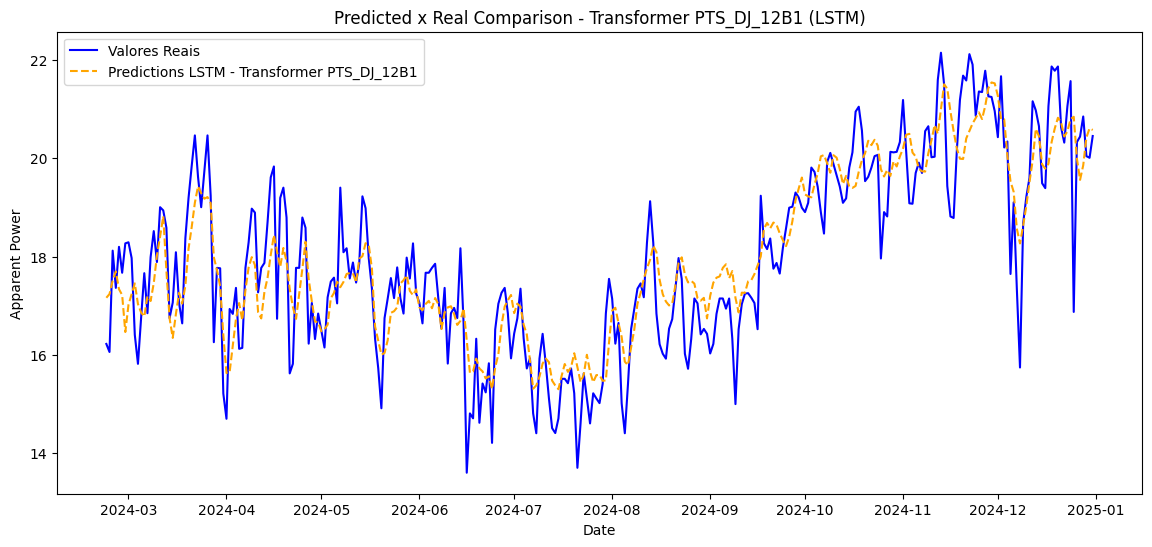

Resultados SVR:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1    SVR  1.24 1.00 0.58

Resultados LSTM:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1   LSTM  0.88 0.69 0.79


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import random

# Fixando seeds para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

def plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo):
    plt.figure(figsize=(14, 6))
    plt.plot(df_previsoes, y_test_inverso, label='Valores Reais', color='blue')
    plt.plot(df_previsoes, y_pred, label=f'Predictions {modelo} - Transformer {trafo}', linestyle='--', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Apparent Power')
    plt.title(f'Predicted x Real Comparison - Transformer {trafo} ({modelo})')
    plt.legend()
    plt.show()

def treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo, janela, epochs=20, batch_size=32):
    resultados = []

    for trafo in trafos_escolhidos:
        df = df_filtrado[df_filtrado['TRAFO'] == trafo]
        df = df[['datahora', 'S',  'fornec_ALTA', 'fornec_BAIXA', 'temp', 'precip',	'cloudcover',	'solarradiation']]
        df = df.set_index(['datahora']).resample('D').max()
        df.sort_index(inplace=True)
        df = df.interpolate(method='linear')

        dados = df[['S', 'fornec_ALTA', 'fornec_BAIXA', 'temp', 'precip',	'cloudcover',	'solarradiation']].values
        scaler_features = MinMaxScaler(feature_range=(0, 1))
        dados_normalizados = scaler_features.fit_transform(dados)

        scaler_S = MinMaxScaler(feature_range=(0, 1))
        S_normalizado = scaler_S.fit_transform(df[['S']].values)

        X, y = [], []
        for i in range(janela, len(dados_normalizados)):
            X.append(dados_normalizados[i-janela:i, :])
            y.append(dados_normalizados[i, 0])  # Prevendo apenas "S"

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2])) if modelo == 'LSTM' else X.reshape(X.shape[0], -1)

        split = int(len(X) * 0.83)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        if modelo == 'SVR':
            regressor = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=0.01)

        elif modelo == 'RFR':
            regressor = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt', n_jobs=-1, random_state=42)

        elif modelo == 'LSTM':
            regressor = Sequential()
            regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            regressor.add(LSTM(units=50))
            regressor.add(Dense(1))
            regressor.compile(optimizer='adam', loss='mean_squared_error')
            regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        regressor.fit(X_train, y_train) if modelo != 'LSTM' else None

        y_pred_normalizado = regressor.predict(X_test)  # forma (n_amostras, 1)
        y_pred = scaler_S.inverse_transform(y_pred_normalizado.reshape(-1, 1))
        y_test_inverso = scaler_S.inverse_transform(y_test.reshape(-1, 1))


        mse = mean_squared_error(y_test_inverso, y_pred)
        rmse = sqrt(mse)
        mae = mean_absolute_error(y_test_inverso, y_pred)
        r2 = r2_score(y_test_inverso, y_pred)

        df_previsoes = df.index[split + janela:]
        plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo)

        resultados.append({
            'Trafo': trafo,
            'Modelo': modelo,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

    return pd.DataFrame(resultados)

# Chamando para SVR, RFR e LSTM
resultados_svr_S_Clientes_Clima = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='SVR', janela=365)
# resultados_rfr = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='RFR', janela=365)
resultados_lstm_S_Clientes_Clima = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='LSTM', janela=365, epochs=20, batch_size=32)

print("Resultados SVR:")
print(resultados_svr_S_Clientes_Clima)
# print("\nResultados RFR:")
# print(resultados_rfr)
print("\nResultados LSTM:")
print(resultados_lstm_S_Clientes_Clima)

#### S + Clientes + Potência Acumulada GD

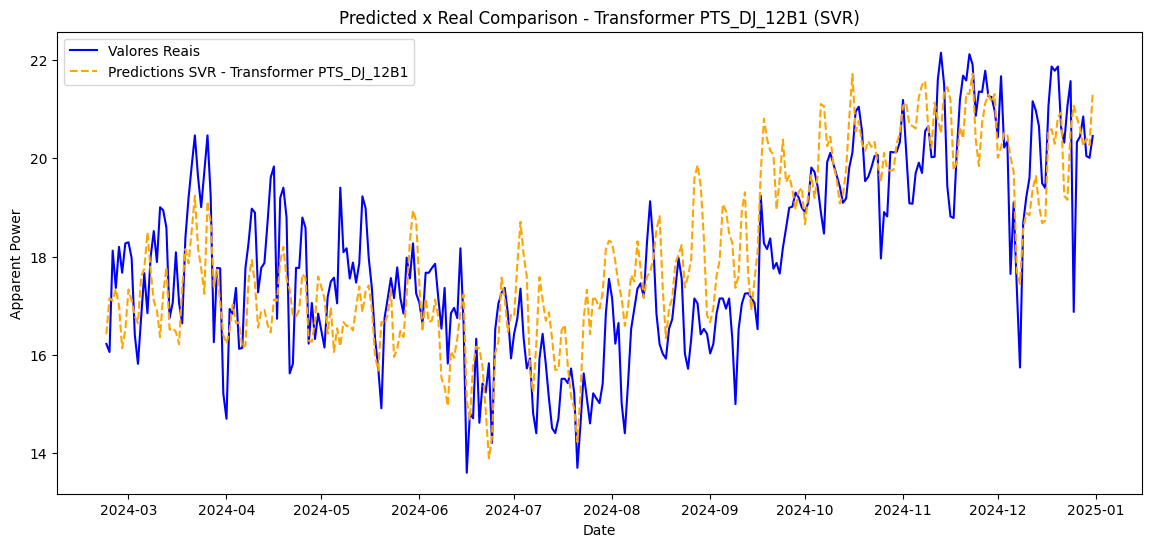

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step


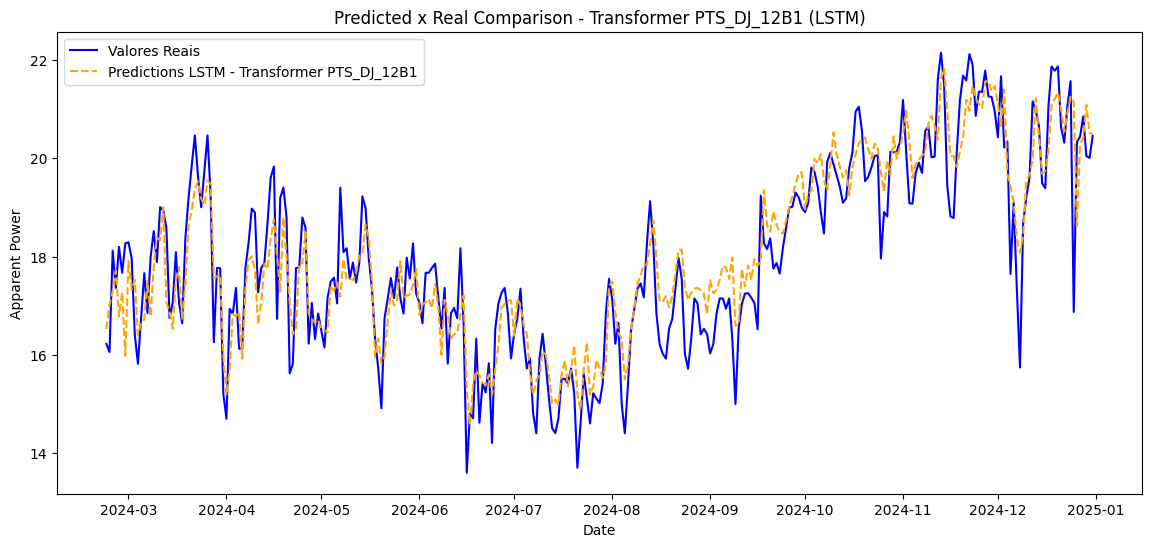

Resultados SVR:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1    SVR  1.22 0.99 0.59

Resultados LSTM:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1   LSTM  0.79 0.61 0.83


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import random

# Fixando seeds para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

def plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo):
    plt.figure(figsize=(14, 6))
    plt.plot(df_previsoes, y_test_inverso, label='Valores Reais', color='blue')
    plt.plot(df_previsoes, y_pred, label=f'Predictions {modelo} - Transformer {trafo}', linestyle='--', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Apparent Power')
    plt.title(f'Predicted x Real Comparison - Transformer {trafo} ({modelo})')
    plt.legend()
    plt.show()

def treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo, janela, epochs=20, batch_size=32):
    resultados = []

    for trafo in trafos_escolhidos:
        df = df_filtrado[df_filtrado['TRAFO'] == trafo]
        df = df[['datahora', 'S', 'PotenciaAcumulada', 'fornec_ALTA', 'fornec_BAIXA', 'temp', 'precip',	'cloudcover',	'solarradiation']]
        df = df.set_index(['datahora']).resample('D').max()
        df.sort_index(inplace=True)
        df = df.interpolate(method='linear')

        dados = df[['S', 'PotenciaAcumulada', 'fornec_ALTA', 'fornec_BAIXA', 'temp', 'precip',	'cloudcover',	'solarradiation']].values
        scaler_features = MinMaxScaler(feature_range=(0, 1))
        dados_normalizados = scaler_features.fit_transform(dados)

        scaler_S = MinMaxScaler(feature_range=(0, 1))
        S_normalizado = scaler_S.fit_transform(df[['S']].values)

        X, y = [], []
        for i in range(janela, len(dados_normalizados)):
            X.append(dados_normalizados[i-janela:i, :])
            y.append(dados_normalizados[i, 0])  # Prevendo apenas "S"

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2])) if modelo == 'LSTM' else X.reshape(X.shape[0], -1)

        split = int(len(X) * 0.83)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        if modelo == 'SVR':
            regressor = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=0.01)

        elif modelo == 'RFR':
            regressor = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt', n_jobs=-1, random_state=42)

        elif modelo == 'LSTM':
            regressor = Sequential()
            regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            regressor.add(LSTM(units=50))
            regressor.add(Dense(1))
            regressor.compile(optimizer='adam', loss='mean_squared_error')
            regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        regressor.fit(X_train, y_train) if modelo != 'LSTM' else None

        y_pred_normalizado = regressor.predict(X_test)  # forma (n_amostras, 1)
        y_pred = scaler_S.inverse_transform(y_pred_normalizado.reshape(-1, 1))
        y_test_inverso = scaler_S.inverse_transform(y_test.reshape(-1, 1))


        mse = mean_squared_error(y_test_inverso, y_pred)
        rmse = sqrt(mse)
        mae = mean_absolute_error(y_test_inverso, y_pred)
        r2 = r2_score(y_test_inverso, y_pred)

        df_previsoes = df.index[split + janela:]
        plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo)

        resultados.append({
            'Trafo': trafo,
            'Modelo': modelo,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

    return pd.DataFrame(resultados)

# Chamando para SVR, RFR e LSTM
resultados_svr_S_Clientes_GD_Clima = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='SVR', janela=365)
# resultados_rfr = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='RFR', janela=365)
resultados_lstm_S_Clientes_GD_Clima = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='LSTM', janela=365, epochs=20, batch_size=32)

print("Resultados SVR:")
print(resultados_svr_S_Clientes_GD_Clima)
# print("\nResultados RFR:")
# print(resultados_rfr)
print("\nResultados LSTM:")
print(resultados_lstm_S_Clientes_GD_Clima)

In [ ]:
print("Resultados SVR - S + GD:")
print(resultados_svr_S_GD_Clima)

print("Resultados SVR - S + Clientes:")
print(resultados_svr_S_Clientes_Clima)

print("Resultados SVR - S + Clientes + GD:")
print(resultados_svr_S_Clientes_GD_Clima)

print("Resultados SVR - S + GD:")
print(resultados_lstm_S_GD_Clima)

print("Resultados SVR - S + Clientes:")
print(resultados_lstm_S_Clientes_Clima)

print("Resultados SVR - S + Clientes + GD:")
print(resultados_lstm_S_Clientes_GD_Clima)



Resultados SVR - S + GD:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1    SVR  1.26 1.04 0.56
Resultados SVR - S + Clientes:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1    SVR  1.24 1.00 0.58
Resultados SVR - S + Clientes + GD:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1    SVR  1.22 0.99 0.59
Resultados SVR - S + GD:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1   LSTM  0.86 0.68 0.80
Resultados SVR - S + Clientes:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1   LSTM  0.88 0.69 0.79
Resultados SVR - S + Clientes + GD:
         Trafo Modelo  RMSE  MAE   R2
0  PTS_DJ_12B1   LSTM  0.79 0.61 0.83
